## load base files

In [1]:
!git clone https://github.com/pedropro/TACO.git

Cloning into 'TACO'...
remote: Enumerating objects: 740, done.
remote: Counting objects: 100% (435/435), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 740 (delta 416), reused 380 (delta 380), pack-reused 305 (from 1)
Receiving objects: 100% (740/740), 97.48 MiB | 15.19 MiB/s, done.
Resolving deltas: 100% (499/499), done.


In [2]:
%cd TACO
! python download.py
%cd ..

/content/TACO
Note. If for any reason the connection is broken. Just call me again and I will start where I left.
Finished
/content


In [3]:
import os

# Check the number of batch folders downloaded
data_path = 'TACO/data/'
batches = [folder for folder in os.listdir(data_path) if folder.startswith('batch_')]
print(f"Total number of batches: {len(batches)}")

Total number of batches: 15


In [4]:
import json
import os

# Path to the annotations file
annotations_path = 'TACO/data/annotations.json'

# Check if the annotations file exists
if os.path.exists(annotations_path):
    with open(annotations_path, 'r') as f:
        data = json.load(f)

    # Get the number of images, categories, and annotations
    num_images = len(data['images'])  # List of images
    num_categories = len(data['categories'])  # List of categories
    num_annotations = len(data['annotations'])  # List of annotations

    print(f"Number of images: {num_images}")
    print(f"Number of categories: {num_categories}")
    print(f"Number of annotations: {num_annotations}")
else:
    print(f"Annotations file not found at: {annotations_path}")


Number of images: 1500
Number of categories: 60
Number of annotations: 4784


In [5]:
import json

# Load the annotations file
with open('TACO/data/annotations.json') as f:
    data = json.load(f)

## convert data into yolo format

In [6]:
import json
import os
from pathlib import Path
import shutil

# Paths to your TACO dataset
coco_json_path = 'TACO/data/annotations.json'  # Path to TACO's annotations file
images_dir = 'TACO/data'                       # Path to TACO's main image directory with batch subfolders
output_dir = 'yolo_top_categories'             # Base directory for YOLO format

# Ensure output directories for images and labels
Path(output_dir, 'images').mkdir(parents=True, exist_ok=True)
Path(output_dir, 'labels').mkdir(parents=True, exist_ok=True)

# Load TACO annotations
with open(coco_json_path, 'r') as f:
    data = json.load(f)

# Get category mappings
categories = {category['id']: category['name'] for category in data['categories']}

# Counter for unique filenames
file_counter = 1

# Process each image and corresponding annotations
for img in data['images']:
    img_id = img['id']
    img_file_name = img['file_name']  # This should be in the format 'batch_x/filename.jpg'
    img_width, img_height = img['width'], img['height']

    # Derive the image path within one of the 15 batch folders
    img_path = os.path.join(images_dir, img_file_name)

    # Create a unique integer-based name for each image and label
    unique_name = str(file_counter)
    img_extension = os.path.splitext(img_file_name)[1]  # Preserve the original extension (e.g., .jpg, .png)

    # Copy image to the images directory with the new unique name
    output_image_path = os.path.join(output_dir, 'images', unique_name + img_extension)
    if os.path.exists(img_path):
        shutil.copy(img_path, output_image_path)

        # Create a corresponding label file with the same unique integer name
        label_file_path = os.path.join(output_dir, 'labels', unique_name + '.txt')
        with open(label_file_path, 'w') as label_file:
            # Find all annotations for the current image
            for ann in data['annotations']:
                if ann['image_id'] == img_id:
                    category_id = ann['category_id']
                    # Ensure the category is in our mapping
                    if category_id in categories:
                        # YOLO format requires x_center, y_center, width, and height normalized
                        x, y, width, height = ann['bbox']
                        x_center = (x + width / 2) / img_width
                        y_center = (y + height / 2) / img_height
                        width /= img_width
                        height /= img_height

                        # Write the label file in YOLO format: <class_id> <x_center> <y_center> <width> <height>
                        label_file.write(f"{category_id} {x_center} {y_center} {width} {height}\n")

        # Increment the counter for the next file
        file_counter += 1

# Print the total number of images moved
print(f"Total number of images processed: {file_counter - 1}")

Total number of images processed: 1500


## deleting unwanted categories

In [7]:
import os
import json

# Step 1: Define the category mapping for the categories of interest
desired_categories = {
    36: 0,  # Plastic film
    58: 1,  # Unlabeled litter
    59: 2,  # Cigarette
    5: 3,   # Clear plastic bottle
    7: 4,   # Plastic bottle cap
    39: 5,  # Other plastic wrapper
    12: 6,  # Drink can
    29: 7,  # Other plastic
}

# Step 2: Define path to annotations and labels directory

label_dir = 'yolo_top_categories/labels'

# Step 3: Initialize counters for total images and deleted images
total_images = len(data['images'])
deleted_image_ids = set()

# Step 4: Loop through annotations and filter out unwanted categories
for ann in data['annotations']:
    if ann['category_id'] not in desired_categories:
        deleted_image_ids.add(ann['image_id'])  # Mark images to be deleted

# Step 5: Update the label files to reflect only desired categories and new IDs
for label_file in os.listdir(label_dir):
    label_file_path = os.path.join(label_dir, label_file)

    # Read the original label data
    with open(label_file_path, 'r') as file:
        lines = file.readlines()

    # Prepare a list to hold the updated lines
    updated_lines = []

    # Process each line in the label file
    for line in lines:
        parts = line.strip().split()
        category_id = int(parts[0])

        # Check if the category ID is in the desired mapping
        if category_id in desired_categories:
            # Update the category ID to the new mapping
            new_category_id = desired_categories[category_id]

            # Create the updated line with the new category ID
            updated_line = f"{new_category_id} " + " ".join(parts[1:]) + "\n"
            updated_lines.append(updated_line)

    # Write the updated lines back to the label file
    with open(label_file_path, 'w') as file:
        file.writelines(updated_lines)

print("Label files have been updated with only the specified categories and new IDs.")

Label files have been updated with only the specified categories and new IDs.


## delete files that don't contain objects of interest

In [8]:
import os

# Path to the base directory containing unified 'images' and 'labels' folders
base_dir = 'yolo_top_categories'  # Adjust if necessary
label_dir = os.path.join(base_dir, 'labels')
image_dir = os.path.join(base_dir, 'images')

# Initialize a counter for deleted files
total_deleted_files = 0

# Loop over each label file in the labels directory
for label_file in os.listdir(label_dir):
    label_file_path = os.path.join(label_dir, label_file)

    # Check if the label file is empty
    if os.path.getsize(label_file_path) == 0:
        # Construct possible image file paths
        base_image_name = os.path.splitext(label_file)[0]
        image_file_path_jpg = os.path.join(image_dir, base_image_name + '.jpg')
        image_file_path_jpg_upper = os.path.join(image_dir, base_image_name + '.JPG')

        # Delete the label file
        os.remove(label_file_path)
        total_deleted_files += 1

        # Delete the associated image file if it exists
        if os.path.exists(image_file_path_jpg):
            os.remove(image_file_path_jpg)
            total_deleted_files += 1
        elif os.path.exists(image_file_path_jpg_upper):
            os.remove(image_file_path_jpg_upper)
            total_deleted_files += 1

# Print the total number of files deleted
print(f"Total number of files deleted (label and image): {total_deleted_files}")

Total number of files deleted (label and image): 828


## split the data into train/val/test sections

In [9]:
import shutil
import random

random.seed(42)

# Set the split ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Ensure output directories for each split
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(base_dir, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(base_dir, split, 'labels'), exist_ok=True)

# Get a list of all images and shuffle them
all_images = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
random.shuffle(all_images)

# Calculate split sizes
num_train = int(len(all_images) * train_ratio)
num_val = int(len(all_images) * val_ratio)

# Assign images to each split
train_images = all_images[:num_train]
val_images = all_images[num_train:num_train + num_val]
test_images = all_images[num_train + num_val:]

# Move files to their respective split directories
for split, images in zip(['train', 'val', 'test'], [train_images, val_images, test_images]):
    for image_file in images:
        # Move image file
        src_image_path = os.path.join(image_dir, image_file)
        dst_image_path = os.path.join(base_dir, split, 'images', image_file)
        shutil.move(src_image_path, dst_image_path)

        # Move corresponding label file
        label_file = os.path.splitext(image_file)[0] + '.txt'
        src_label_path = os.path.join(label_dir, label_file)
        dst_label_path = os.path.join(base_dir, split, 'labels', label_file)
        if os.path.exists(src_label_path):  # Ensure corresponding label file exists
            shutil.move(src_label_path, dst_label_path)

# Print the number of images in each split
print(f"Number of images in train: {len(train_images)}")
print(f"Number of images in val: {len(val_images)}")
print(f"Number of images in test: {len(test_images)}")

Number of images in train: 760
Number of images in val: 217
Number of images in test: 109


## delete images under yolo_top_categories/images and labels

In [10]:
# Paths to the original images and labels directories
image_dir = os.path.join(base_dir, 'images')
label_dir = os.path.join(base_dir, 'labels')

# Delete the original images and labels directories
if os.path.exists(image_dir):
    shutil.rmtree(image_dir)

if os.path.exists(label_dir):
    shutil.rmtree(label_dir)

print("Original images and labels directories have been deleted.")

Original images and labels directories have been deleted.


## find largest size for all categories

In [11]:
import os

def find_largest_category(directory):
    value_per_category = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0}
    image_files = [f for f in os.listdir(os.path.join(directory, 'images')) if f.endswith('.jpg') or f.endswith('.png') or f.endswith('.JPG')]

    for image_file in image_files:
      label_file = os.path.splitext(image_file)[0] + '.txt'
      label_path = os.path.join(directory, 'labels', label_file)

      if os.path.exists(label_path):
        with open(label_path, 'r') as f:
          lines = f.readlines()
          for line in lines:
            category = int(line.split()[0])
            if category in value_per_category:
              value_per_category[category] += 1

    largest_value = max(value_per_category.values())
    print(value_per_category)
    return largest_value

train_data_dir = 'yolo_top_categories/train'
largest_value = find_largest_category(train_data_dir)
print(largest_value)

{0: 322, 1: 400, 2: 483, 3: 216, 4: 153, 5: 201, 6: 181, 7: 194}
483


## copy the images to another directory

In [12]:
def copy_balanced_data(source_dir, dest_dir, max_samples_per_class):
  """
  Copies images and labels from source_dir to dest_dir, ensuring a balanced dataset
  with a maximum number of samples per class.
  """
  os.makedirs(os.path.join(dest_dir, 'images'), exist_ok=True)
  os.makedirs(os.path.join(dest_dir, 'labels'), exist_ok=True)

  class_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
  image_files = [f for f in os.listdir(os.path.join(source_dir, 'images')) if f.endswith('.jpg') or f.endswith('.png') or f.endswith('.JPG')]

  for image_file in image_files:
    label_file = os.path.splitext(image_file)[0] + '.txt'
    label_path = os.path.join(source_dir, 'labels', label_file)

    if os.path.exists(label_path):
      with open(label_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
          category = int(line.split()[0])
          if category in class_counts and class_counts[category] < max_samples_per_class:
            # Copy image
            src_image_path = os.path.join(source_dir, 'images', image_file)
            dst_image_path = os.path.join(dest_dir, 'images', image_file)
            shutil.copy(src_image_path, dst_image_path)

            # Copy label
            src_label_path = os.path.join(source_dir, 'labels', label_file)
            dst_label_path = os.path.join(dest_dir, 'labels', label_file)
            shutil.copy(src_label_path, dst_label_path)

            class_counts[category] += 1
            break  # Only consider the first class in the image

# Example usage
source_dir = 'yolo_top_categories/train'
dest_dir = 'yolo_top_categories/balanced_train'
max_samples_per_class = largest_value

copy_balanced_data(source_dir, dest_dir, max_samples_per_class)

## balance train dataset

In [13]:
def oversample_train_data(train_data_dir, largest_value):
    """Oversamples the training data to ensure a balanced dataset.

    Args:
        train_data_dir: Path to the training data directory.
        largest_value: The largest number of samples for any category in the train data.
    """

    label_dir = os.path.join(train_data_dir, 'labels')
    image_dir = os.path.join(train_data_dir, 'images')

    category_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
    for label_file in os.listdir(label_dir):
        label_path = os.path.join(label_dir, label_file)
        with open(label_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                category = int(line.split()[0])
                if category in category_counts:
                    category_counts[category] += 1

    for category, count in category_counts.items():
        if count < largest_value:
            num_to_duplicate = largest_value - count
            image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png') or f.endswith('.JPG')]
            category_images = []
            for image_file in image_files:
                label_file = os.path.splitext(image_file)[0] + '.txt'
                label_path = os.path.join(label_dir, label_file)
                if os.path.exists(label_path):
                    with open(label_path, 'r') as f:
                        lines = f.readlines()
                        for line in lines:
                            if int(line.split()[0]) == category:
                                category_images.append(image_file)
                                break

            for _ in range(num_to_duplicate):
                if category_images:
                    image_to_duplicate = random.choice(category_images)
                    new_image_name = str(uuid.uuid4()) + os.path.splitext(image_to_duplicate)[1]

                    src_image_path = os.path.join(image_dir, image_to_duplicate)
                    dst_image_path = os.path.join(image_dir, new_image_name)
                    shutil.copy(src_image_path, dst_image_path)

                    src_label_path = os.path.join(label_dir, os.path.splitext(image_to_duplicate)[0] + '.txt')
                    dst_label_path = os.path.join(label_dir, os.path.splitext(new_image_name)[0] + '.txt')
                    shutil.copy(src_label_path, dst_label_path)

# Example usage:
import uuid
train_data_dir = 'yolo_top_categories/balanced_train'
largest_value = find_largest_category(train_data_dir)
oversample_train_data(train_data_dir, largest_value)

{0: 322, 1: 400, 2: 483, 3: 216, 4: 153, 5: 201, 6: 181, 7: 194}


## ensure that all the categories are balanced

In [14]:
from collections import Counter
import matplotlib.pyplot as plt

# Function to plot label counts for a given split
def plot_label_counts(label_names, folders):
    # Loop through each split and calculate label distributions
    for split in folders:
        label_dir_split = os.path.join(base_dir, split, 'labels')

        # Initialize a counter for label counts for the current split
        label_counts = Counter()

        # Loop over each label file in the current label directory
        for label_file in os.listdir(label_dir_split):
            label_file_path = os.path.join(label_dir_split, label_file)

            # Read the label file
            with open(label_file_path, 'r') as file:
                lines = file.readlines()

                # Count each label in the file
                for line in lines:
                    parts = line.strip().split()
                    label_id = int(parts[0])  # The label ID is the first element
                    label_counts[label_id] += 1
        # Convert label IDs to label names and sort by count
        labels, counts = zip(*sorted(
            [(label_names[label_id], count) for label_id, count in label_counts.items()],
            key=lambda x: x[1]
        ))

        # Plotting a horizontal bar chart for the split
        plt.figure(figsize=(10, 6))
        plt.barh(labels, counts, color='skyblue')
        plt.xlabel("Count")
        plt.ylabel("Label Name")
        plt.title(f"Counts of Object Labels in {split.capitalize()} Dataset")
        plt.show()

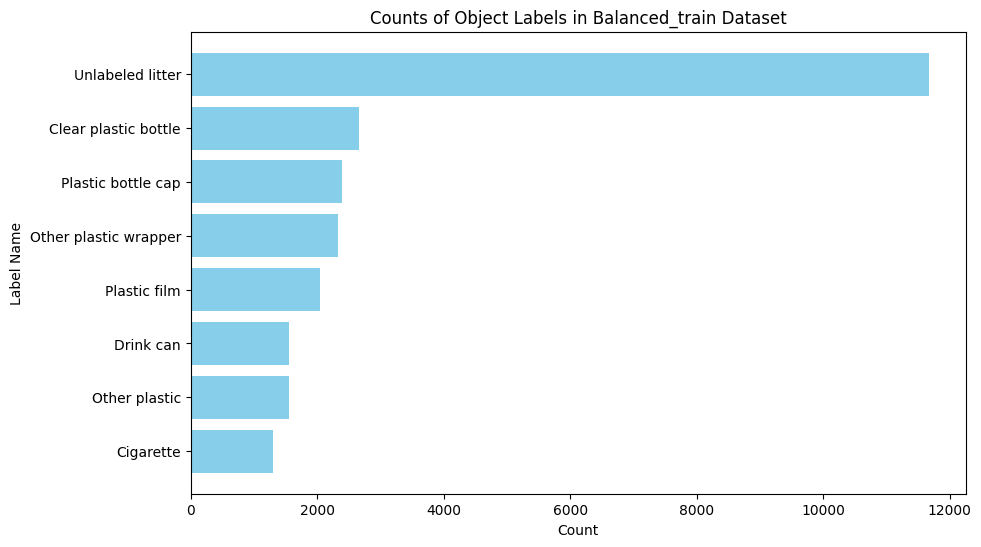

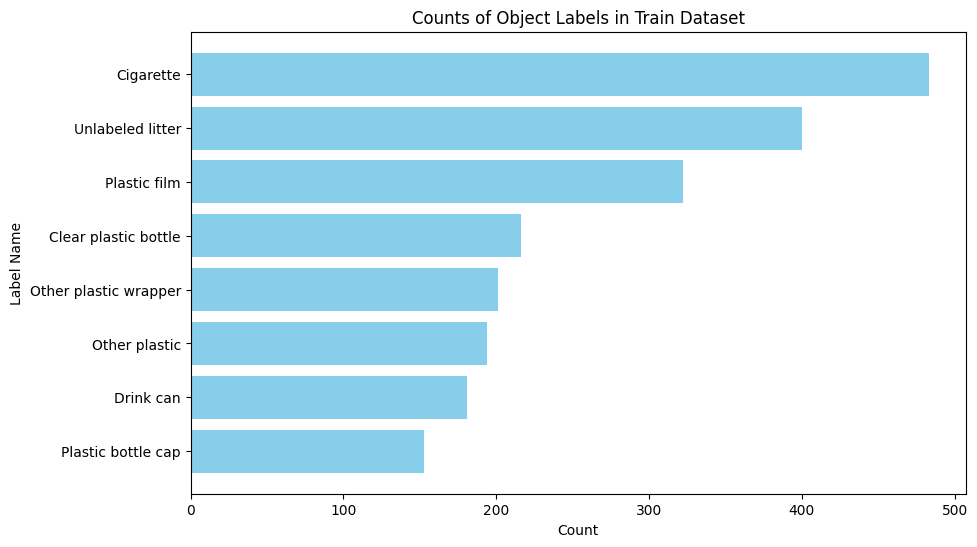

In [15]:
# Define a mapping from label IDs to names
label_names = {
    0: "Plastic film",
    1: "Unlabeled litter",
    2: "Cigarette",
    3: "Clear plastic bottle",
    4: "Plastic bottle cap",
    5: "Other plastic wrapper",
    6: "Drink can",
    7: "Other plastic",
}
# Plot label counts for the current split
plot_label_counts(label_names, ['balanced_train', 'train'])

In [16]:
def undersample_largest_class(train_data_dir):
  """Undersamples the class with the highest count in the training data.

  Args:
      train_data_dir: Path to the training data directory.
  """

  label_dir = os.path.join(train_data_dir, 'labels')
  image_dir = os.path.join(train_data_dir, 'images')

  category_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
  for label_file in os.listdir(label_dir):
      label_path = os.path.join(label_dir, label_file)
      with open(label_path, 'r') as f:
          lines = f.readlines()
          for line in lines:
              category = int(line.split()[0])
              if category in category_counts:
                  category_counts[category] += 1

  # Find the class with the largest count
  largest_class = max(category_counts, key=category_counts.get)
  largest_count = category_counts[largest_class]

  # Find the target count for undersampling (e.g., the second largest count)
  second_largest_count = sorted(category_counts.values())[-2] if len(category_counts) > 1 else largest_count

  # Remove images belonging to the largest class until its count matches the target count
  images_to_remove = []
  for image_file in os.listdir(image_dir):
      label_file = os.path.splitext(image_file)[0] + '.txt'
      label_path = os.path.join(label_dir, label_file)
      if os.path.exists(label_path):
          with open(label_path, 'r') as f:
              lines = f.readlines()
              for line in lines:
                  if int(line.split()[0]) == largest_class:
                      if category_counts[largest_class] > second_largest_count:
                          images_to_remove.append(image_file)
                          category_counts[largest_class] -= 1
                          break

  for image_file in images_to_remove:
      image_path = os.path.join(image_dir, image_file)
      label_path = os.path.join(label_dir, os.path.splitext(image_file)[0] + '.txt')
      if os.path.exists(image_path):
          os.remove(image_path)
      if os.path.exists(label_path):
          os.remove(label_path)

# Example usage:
train_data_dir = 'yolo_top_categories/balanced_train'
undersample_largest_class(train_data_dir)

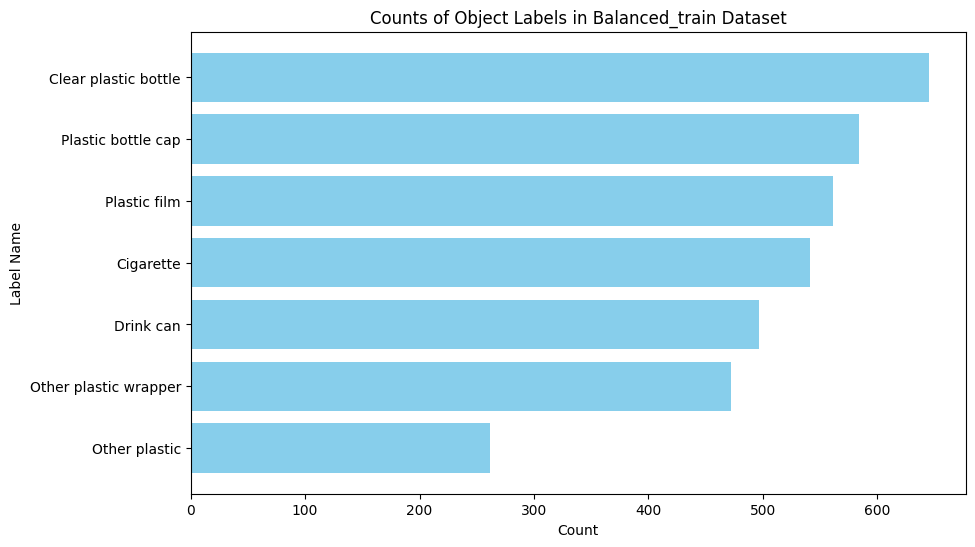

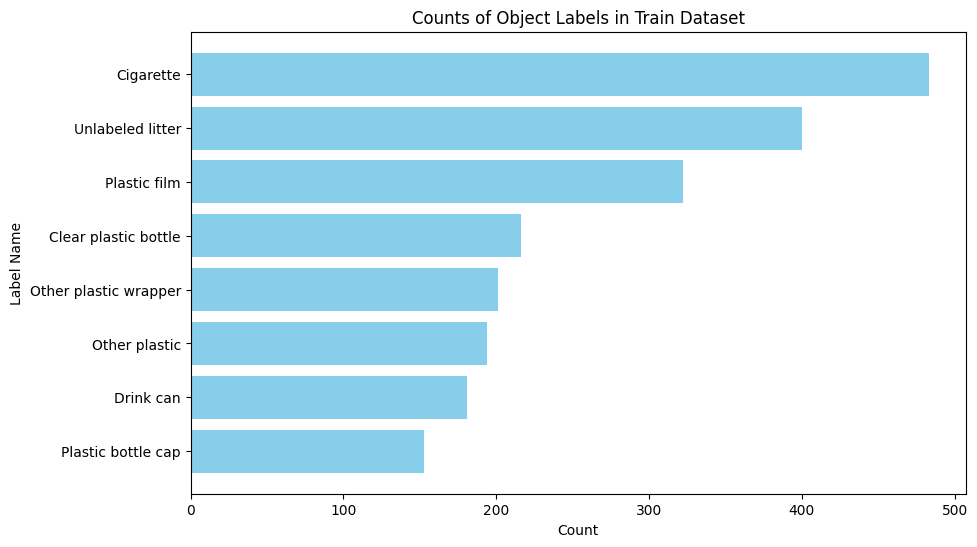

In [17]:
# Define a mapping from label IDs to names
label_names = {
    0: "Plastic film",
    1: "Unlabeled litter",
    2: "Cigarette",
    3: "Clear plastic bottle",
    4: "Plastic bottle cap",
    5: "Other plastic wrapper",
    6: "Drink can",
    7: "Other plastic",
}
# Plot label counts for the current split
plot_label_counts(label_names, ['balanced_train', 'train'])

In [18]:
import os
import json

# desired_categories = {
#     36: 0,  # Plastic film
#     58: 1,  # Unlabeled litter
#     59: 2,  # Cigarette
#     5: 3,   # Clear plastic bottle
#     7: 4,   # Plastic bottle cap
#     39: 5,  # Other plastic wrapper
#     12: 6,  # Drink can
#     29: 7,  # Other plastic
# }

# Step 1: Define the category mapping for the categories of interest
desired_categories = {
    0: 0,   # Plastic film
    1: 1,   # Unlabeled litter
    2: 2,   # Cigarette
    3: 3,   # Clear plastic bottle
    4: 4,   # Plastic bottle cap
    5: 5,   # Other plastic wrapper,
    6: 6,   # drink can
}

# Step 2: Define path to annotations and labels directory

label_dir = 'yolo_top_categories/balanced_train/labels'

# Step 3: Initialize counters for total images and deleted images
total_images = len(data['images'])
deleted_image_ids = set()

# Step 4: Loop through annotations and filter out unwanted categories
for ann in data['annotations']:
    if ann['category_id'] not in desired_categories:
        deleted_image_ids.add(ann['image_id'])  # Mark images to be deleted

# Step 5: Update the label files to reflect only desired categories and new IDs
for label_file in os.listdir(label_dir):
    label_file_path = os.path.join(label_dir, label_file)

    # Read the original label data
    with open(label_file_path, 'r') as file:
        lines = file.readlines()

    # Prepare a list to hold the updated lines
    updated_lines = []

    # Process each line in the label file
    for line in lines:
        parts = line.strip().split()
        category_id = int(parts[0])

        # Check if the category ID is in the desired mapping
        if category_id in desired_categories:
            # Update the category ID to the new mapping
            new_category_id = desired_categories[category_id]

            # Create the updated line with the new category ID
            updated_line = f"{new_category_id} " + " ".join(parts[1:]) + "\n"
            updated_lines.append(updated_line)

    # Write the updated lines back to the label file
    with open(label_file_path, 'w') as file:
        file.writelines(updated_lines)

print("Label files have been updated with only the specified categories and new IDs.")

Label files have been updated with only the specified categories and new IDs.


In [19]:
import os

# Path to the base directory containing unified 'images' and 'labels' folders
base_dir = 'yolo_top_categories/balanced_train'  # Adjust if necessary
label_dir = os.path.join(base_dir, 'labels')
image_dir = os.path.join(base_dir, 'images')

# Initialize a counter for deleted files
total_deleted_files = 0

# Loop over each label file in the labels directory
for label_file in os.listdir(label_dir):
    label_file_path = os.path.join(label_dir, label_file)

    # Check if the label file is empty
    if os.path.getsize(label_file_path) == 0:
        # Construct possible image file paths
        base_image_name = os.path.splitext(label_file)[0]
        image_file_path_jpg = os.path.join(image_dir, base_image_name + '.jpg')
        image_file_path_jpg_upper = os.path.join(image_dir, base_image_name + '.JPG')

        # Delete the label file
        os.remove(label_file_path)
        total_deleted_files += 1

        # Delete the associated image file if it exists
        if os.path.exists(image_file_path_jpg):
            os.remove(image_file_path_jpg)
            total_deleted_files += 1
        elif os.path.exists(image_file_path_jpg_upper):
            os.remove(image_file_path_jpg_upper)
            total_deleted_files += 1

# Print the total number of files deleted
print(f"Total number of files deleted (label and image): {total_deleted_files}")

Total number of files deleted (label and image): 204


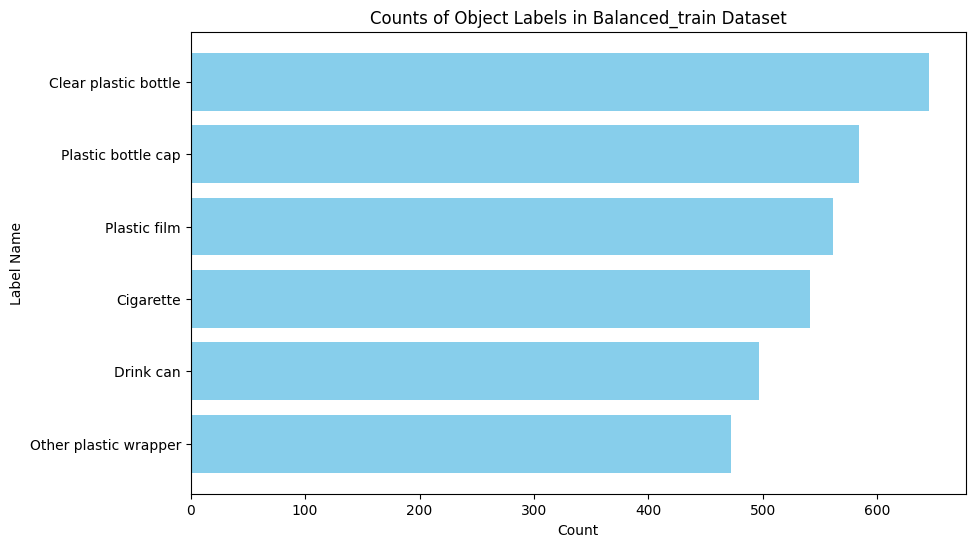

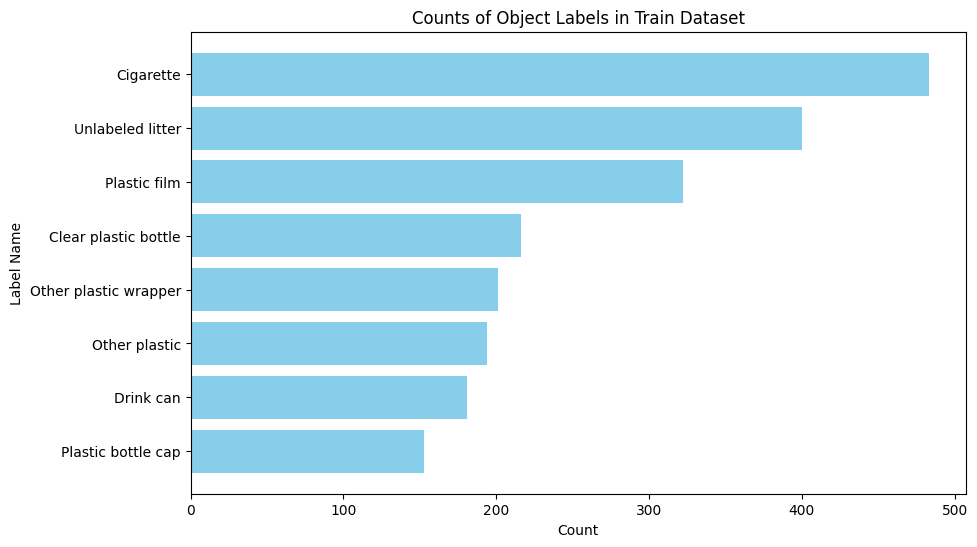

In [20]:
# Define a mapping from label IDs to names
base_dir = 'yolo_top_categories'
label_names = {
    0: "Plastic film",
    1: "Unlabeled litter",
    2: "Cigarette",
    3: "Clear plastic bottle",
    4: "Plastic bottle cap",
    5: "Other plastic wrapper",
    6: "Drink can",
    7: "Other plastic",
}
# Plot label counts for the current split
plot_label_counts(label_names, ['balanced_train', 'train'])

## model training

In [21]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.3/886.3 kB 51.6 MB/s eta 0:00:00


In [22]:
from ultralytics import YOLO

# change the model as needed
model = YOLO('yolov8l.pt')

results = model.train(data='data.yaml', cfg='hyp.yaml')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 83.7M/83.7M [00:02<00:00, 42.6MB/s]


Ultralytics 8.3.31 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=data.yaml, epochs=100, time=None, patience=15, batch=16, imgsz=1536, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True

100%|██████████| 755k/755k [00:00<00:00, 101MB/s]


Overriding model.yaml nc=80 with nc=8

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]           
  7                  -1  1   2360320  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 288MB/s]


AMP: checks passed ✅


train: Scanning /content/yolo_top_categories/balanced_train/labels... 1317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1317/1317 [00:01<00:00, 1022.98it/s]

train: New cache created: /content/yolo_top_categories/balanced_train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/yolo_top_categories/val/labels... 217 images, 0 backgrounds, 0 corrupt: 100%|██████████| 217/217 [00:00<00:00, 872.45it/s]

val: New cache created: /content/yolo_top_categories/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1536 train, 1536 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      19.3G      1.837      4.601      2.009         39       1536: 100%|██████████| 83/83 [00:40<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.14it/s]

                   all        217        505     0.0485       0.23     0.0284     0.0103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      19.4G      1.696      2.666      1.848         21       1536: 100%|██████████| 83/83 [00:38<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]

                   all        217        505      0.158      0.136     0.0252    0.00782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      18.8G      1.725      2.347      1.881         30       1536: 100%|██████████| 83/83 [00:38<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.07it/s]

                   all        217        505      0.076      0.107     0.0399     0.0102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      18.8G      1.662      2.157      1.821         24       1536: 100%|██████████| 83/83 [00:37<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]

                   all        217        505      0.229      0.231      0.155     0.0483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      18.9G      1.598      1.977      1.786          9       1536: 100%|██████████| 83/83 [00:37<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

                   all        217        505      0.201      0.242      0.159     0.0496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      18.7G      1.563      1.861      1.749         20       1536: 100%|██████████| 83/83 [00:37<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]

                   all        217        505      0.201      0.288      0.158     0.0533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      19.1G      1.539      1.763      1.711         20       1536: 100%|██████████| 83/83 [00:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

                   all        217        505      0.237       0.26      0.188     0.0581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      18.8G      1.501      1.623      1.693         34       1536: 100%|██████████| 83/83 [00:37<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

                   all        217        505      0.245      0.265       0.19     0.0596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100        19G      1.488      1.598      1.673         23       1536: 100%|██████████| 83/83 [00:37<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        217        505      0.232      0.221      0.171     0.0491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      18.7G      1.421      1.552      1.602         15       1536: 100%|██████████| 83/83 [00:37<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]

                   all        217        505      0.275      0.251      0.206     0.0632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      21.7G      1.439       1.47      1.636         12       1536: 100%|██████████| 83/83 [00:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

                   all        217        505      0.231      0.276       0.19     0.0565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      18.8G      1.398      1.405      1.596         25       1536: 100%|██████████| 83/83 [00:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]

                   all        217        505       0.21      0.283       0.19     0.0622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      19.2G      1.414      1.386      1.606         34       1536: 100%|██████████| 83/83 [00:37<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        217        505      0.237      0.232      0.175     0.0452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      18.7G      1.364      1.334      1.583         22       1536: 100%|██████████| 83/83 [00:37<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.30it/s]

                   all        217        505      0.228       0.27      0.183     0.0547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      18.6G      1.364      1.286      1.566         19       1536: 100%|██████████| 83/83 [00:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]

                   all        217        505      0.272      0.252      0.209     0.0595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      18.8G      1.354      1.252      1.537         15       1536: 100%|██████████| 83/83 [00:37<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

                   all        217        505      0.284      0.307      0.255     0.0854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      18.8G      1.308      1.229      1.526         19       1536: 100%|██████████| 83/83 [00:37<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]

                   all        217        505      0.261      0.277      0.236     0.0837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      19.1G      1.306      1.207      1.525         24       1536: 100%|██████████| 83/83 [00:37<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]

                   all        217        505      0.249      0.293      0.214     0.0618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      18.6G      1.283      1.135      1.504         31       1536: 100%|██████████| 83/83 [00:37<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]

                   all        217        505      0.274      0.302      0.233     0.0733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      18.7G      1.282       1.18      1.516         11       1536: 100%|██████████| 83/83 [00:37<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]

                   all        217        505        0.3      0.301      0.245     0.0862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      19.2G       1.28       1.13      1.499         20       1536: 100%|██████████| 83/83 [00:37<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

                   all        217        505      0.303      0.294      0.258     0.0977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100        19G      1.265      1.115      1.491         17       1536: 100%|██████████| 83/83 [00:37<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        217        505      0.294      0.259      0.231     0.0715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      18.7G      1.245      1.055       1.48         30       1536: 100%|██████████| 83/83 [00:37<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]

                   all        217        505      0.249      0.292      0.219     0.0615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      18.7G      1.237      1.046      1.471         20       1536: 100%|██████████| 83/83 [00:37<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

                   all        217        505      0.243      0.291      0.221       0.07



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      19.2G      1.233      1.041      1.454         25       1536: 100%|██████████| 83/83 [00:37<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]

                   all        217        505      0.296      0.288      0.237     0.0739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      19.2G      1.234      1.016      1.448         16       1536: 100%|██████████| 83/83 [00:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]

                   all        217        505      0.284       0.31      0.237     0.0768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      18.5G      1.227      1.002      1.461         20       1536: 100%|██████████| 83/83 [00:37<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]

                   all        217        505      0.266      0.298      0.224     0.0678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      18.8G      1.227     0.9705       1.45         17       1536: 100%|██████████| 83/83 [00:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]

                   all        217        505      0.337      0.307      0.269     0.0903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      19.2G      1.209     0.9715       1.45         45       1536: 100%|██████████| 83/83 [00:37<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]

                   all        217        505      0.343      0.256      0.258     0.0913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      18.5G      1.184     0.9419       1.41         22       1536: 100%|██████████| 83/83 [00:37<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]

                   all        217        505      0.267      0.331      0.254     0.0905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      21.7G      1.169     0.9275      1.419         18       1536: 100%|██████████| 83/83 [00:37<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]

                   all        217        505      0.308       0.31       0.26     0.0994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      18.9G      1.152     0.9174      1.388         33       1536: 100%|██████████| 83/83 [00:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]

                   all        217        505      0.295      0.306      0.257     0.0921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      18.8G      1.167     0.9022      1.407         14       1536: 100%|██████████| 83/83 [00:37<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]

                   all        217        505      0.347      0.321      0.271     0.0921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      18.5G      1.176     0.9153      1.409         19       1536: 100%|██████████| 83/83 [00:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        217        505      0.309       0.33      0.275      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      18.7G      1.125     0.8842      1.373         16       1536: 100%|██████████| 83/83 [00:37<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        217        505      0.302      0.359      0.278      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      18.8G      1.156     0.9073      1.414         10       1536: 100%|██████████| 83/83 [00:37<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        217        505      0.332      0.282      0.248     0.0831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      18.6G      1.124     0.8769      1.385         26       1536: 100%|██████████| 83/83 [00:37<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]

                   all        217        505       0.36       0.28      0.256     0.0839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      19.2G      1.118     0.8438      1.381         17       1536: 100%|██████████| 83/83 [00:37<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

                   all        217        505      0.245      0.304      0.222      0.068



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      18.7G      1.115     0.8245      1.358         22       1536: 100%|██████████| 83/83 [00:37<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]

                   all        217        505      0.303      0.292      0.259      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      18.8G      1.073     0.7827      1.334         20       1536: 100%|██████████| 83/83 [00:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]

                   all        217        505      0.293      0.335      0.275      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      19.2G      1.091     0.8118      1.343         16       1536: 100%|██████████| 83/83 [00:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]

                   all        217        505      0.336      0.295      0.272      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100        19G      1.055     0.7999      1.325         15       1536: 100%|██████████| 83/83 [00:37<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]

                   all        217        505      0.354      0.299      0.278      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      19.2G      1.105     0.8031      1.355         17       1536: 100%|██████████| 83/83 [00:37<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

                   all        217        505      0.345      0.304      0.283      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      18.8G      1.088      0.786       1.35         18       1536: 100%|██████████| 83/83 [00:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

                   all        217        505      0.341      0.285      0.274     0.0961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      19.4G      1.059      0.784      1.329         30       1536: 100%|██████████| 83/83 [00:37<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        217        505      0.322      0.336      0.281      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100        19G      1.071     0.7921      1.327         23       1536: 100%|██████████| 83/83 [00:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        217        505      0.288      0.317      0.263     0.0948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      19.7G      1.082     0.7975      1.347         31       1536: 100%|██████████| 83/83 [00:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]

                   all        217        505      0.307      0.347      0.284      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      21.9G      1.079     0.7933      1.343         40       1536: 100%|██████████| 83/83 [00:37<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        217        505      0.346      0.298      0.268     0.0993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      18.9G      1.061     0.7553      1.318         29       1536: 100%|██████████| 83/83 [00:37<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]

                   all        217        505      0.296      0.353      0.283      0.113
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 34, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



49 epochs completed in 0.583 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 87.8MB
Optimizer stripped from runs/detect/train/weights/best.pt, 87.8MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.31 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 268 layers, 43,612,776 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.75it/s]


                   all        217        505      0.309      0.322      0.275      0.124
          Plastic film         52         81      0.371      0.342      0.243       0.11
      Unlabeled litter         51         75          0          0          0          0
             Cigarette         49        136      0.371      0.346      0.266      0.118
  Clear plastic bottle         45         51       0.51      0.529       0.56      0.253
    Plastic bottle cap         37         40      0.403      0.425      0.377      0.147
 Other plastic wrapper         28         41      0.353      0.319      0.262      0.112
         Other plastic         27         34      0.465      0.618       0.49      0.249
             Drink can         34         47          0          0          0          0
Speed: 0.7ms preprocess, 10.5ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/train
